In [66]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import helpers
import pandas as pd
from skimage import exposure
from PIL import Image
from scipy import ndimage
from skimage.measure import label, regionprops_table, regionprops
from skimage import util
from skimage import filters
from sklearn.feature_extraction import image
import itertools
from sklearn.model_selection import train_test_split
import xgboost
from datetime import datetime
from sklearn import metrics

class imgData:
    """
    Data container class for images for training ML model
    """
    def __init__(self, img, classified_image):
        
        self.footprint1 = np.array(
                        [[1, 1, 1]
                        ,[1, 0, 1]
                        ,[1, 1, 1]]
                        )

        self.footprint2 = np.array(
                        [[1, 1, 1, 1, 1]
                        ,[1, 1, 1, 1, 1]
                        ,[1, 1, 0, 1, 1]
                        ,[1, 1, 1, 1, 1]
                        ,[1, 1, 1, 1, 1]]
                        )

        self.img = img / 255. # normalize image to 0 to 1
        self.classified_image = classified_image
        self.meijering = filters.meijering(img).ravel()
        self.non_local_mean = helpers.zscore(img).ravel()
        self.laplace_25 = filters.laplace(img, ksize=25).ravel()
        self.sato = filters.sato(img).ravel()
        self.sobel = filters.sobel(img).ravel()
        self.median_3 = filters.median(img, selem=self.footprint1).ravel()
        self.maximum_5 = ndimage.maximum_filter(img, footprint=self.footprint2, mode='constant').ravel()
        self.yhat = classified_image.ravel() + 1
        self.df = self._get_dataframe()
        
    def _get_dataframe(self):
        xx, yy = np.meshgrid(np.arange(0, self.img.shape[0], 1)
                            ,np.arange(0, self.img.shape[1], 1))
        df = pd.DataFrame()
        df['x'] = xx.ravel()
        df['y'] = yy.ravel()
        df['meijering'] = self.meijering
        df['non_local_mean'] = self.non_local_mean
        df['laplace_25'] = self.laplace_25
        df['sato'] = self.sato
        df['sobel'] = self.sobel
        df['median_3'] = self.median_3
        df['maximum_5'] = self.maximum_5
        df['yhat'] = self.yhat
        
        return df
    
    def get_xdata(self):
        return self.df[self.df.columns[:-1]]
    
    def get_ydata(self):
        return self.df[self.df.columns[-1]]
    
    def get_coordinates(self):
        return self.df[['x', 'y']]

''

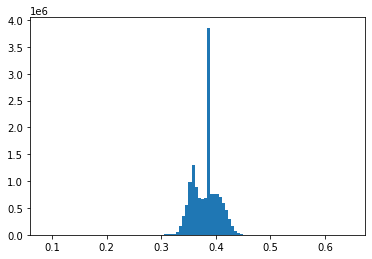

In [179]:
plt.hist(filters.gaussian(train_raw_image).ravel(), bins=100)
''

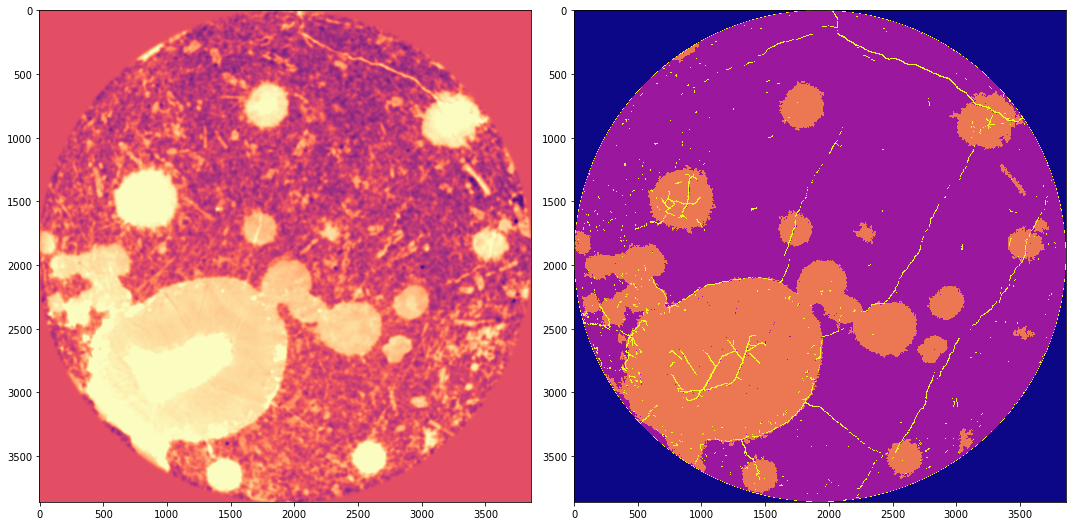

In [182]:
train_raw_image = cv2.imread('benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00015.tif', 0)
train_classified_image = np.load('/media/sda/data/labeled/F20_10b/6um_jamtveit_att_pag-1.99_3.12_00015.tif_labeled.npy')

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(filters.gaussian(train_raw_image, sigma=10), cmap='magma_r', vmin=0.35, vmax=0.45)
ax[1].imshow(train_classified_image, cmap='plasma', interpolation='none')
fig.tight_layout()

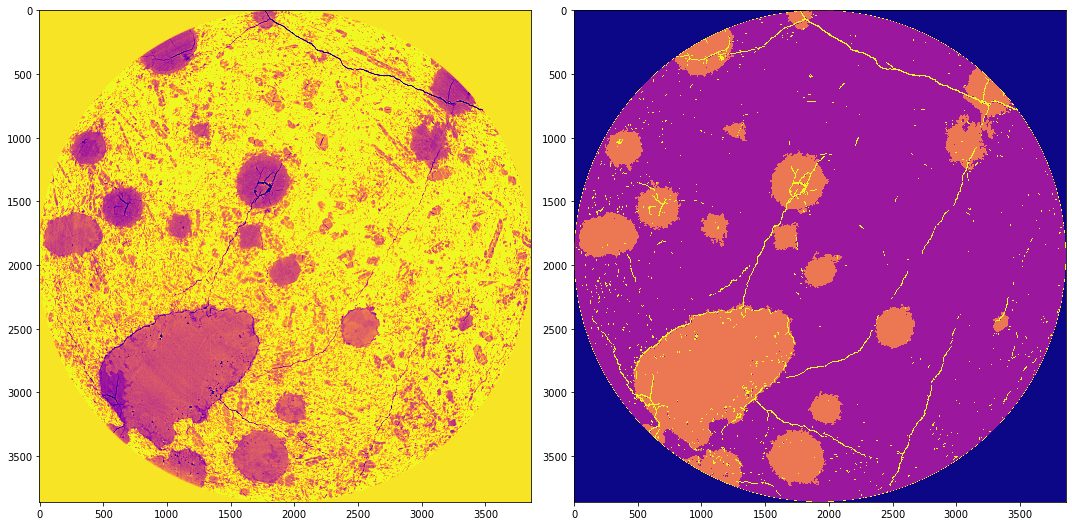

In [3]:
test_raw_image = cv2.imread('benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00510.tif', 0)
test_classified_image = np.load('/media/sda/data/labeled/F20_10b/6um_jamtveit_att_pag-1.99_3.12_00510.tif_labeled.npy')

# img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(test_raw_image, cmap='plasma', vmin=80, vmax=100)
ax[1].imshow(test_classified_image, cmap='plasma', interpolation='none')
fig.tight_layout()

In [4]:
train_data = imgData(train_raw_image, train_classified_image)
test_data = imgData(test_raw_image, test_classified_image)

/home/john/anaconda3/envs/faroe/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


In [5]:
dmatrix_train = xgboost.DMatrix(train_data.get_xdata(), label=train_data.get_ydata())
dmatrix_test = xgboost.DMatrix(test_data.get_xdata(), label=test_data.get_ydata())

In [6]:
params = {'objective':'multi:softmax', 'num_class':4, 'max_depth':2, 'tree_method':'gpu_hist'}

start = datetime.now()
print('started at ', start)

xgb = xgboost.train(params, dmatrix_train, num_boost_round=100, verbose_eval=10)
print('this took', datetime.now()-start)


started at  2021-05-20 15:22:28.094171
[15:22:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
this took 0:00:43.233890


In [7]:
print('jesus says \n IT IS FINISHED')

jesus says 
 IT IS FINISHED


In [8]:
preds_train = xgb.predict(dmatrix_train)

In [9]:
train_img = train_data.get_coordinates().copy()
train_img['rocktype'] = preds_train

In [10]:
train_img.rocktype.unique()

array([0., 3., 1., 2.], dtype=float32)

In [67]:
# helpers.plot_image(helpers.remove_data_based_on_radius(train_img.pivot_table(index='y', columns='x', values='rocktype').values, np.nan))

In [12]:
# preds_test = xgb.predict(dmatrix_test)

In [71]:
test_img = test_data.get_coordinates().copy()
test_img['rocktype'] = preds_test

print(metrics.confusion_matrix(y_true=test_classified_image.ravel(), y_pred=test_img.rocktype))

test_img = test_img.pivot_table(index='y', columns='x', values='rocktype').values

[[      0 3159507   40799    1219     519]
 [      0    1272 9210430  138088   15978]
 [      0      69  160959 1885044    3948]
 [      0     193  127985   29874  115997]
 [      0       0       0       0       0]]


In [68]:
# helpers.plot_image(test_img)

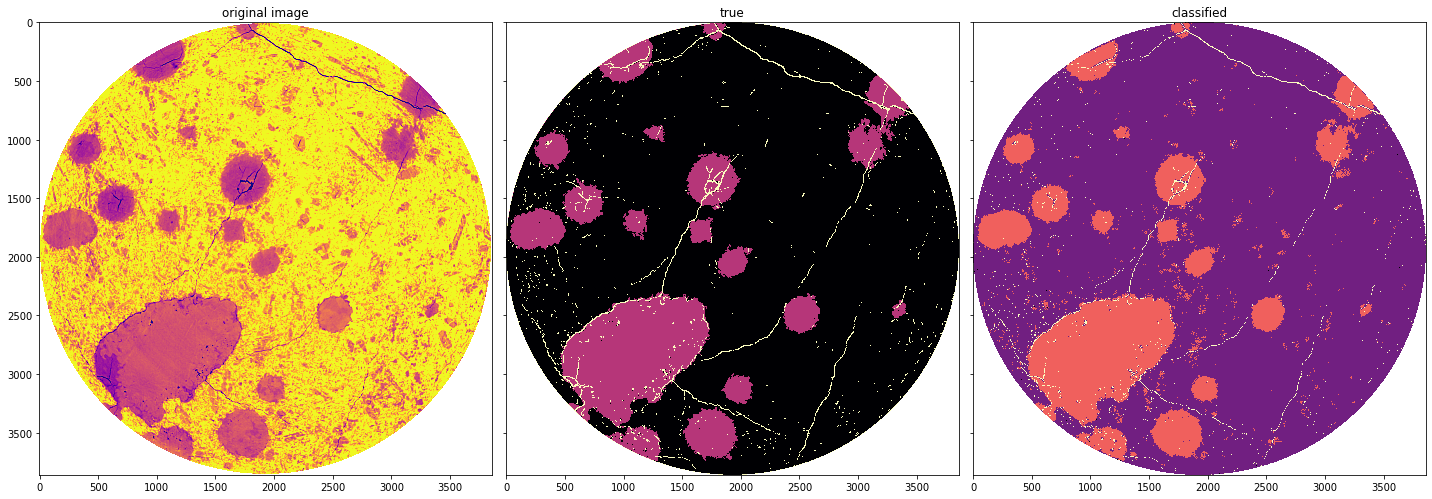

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
ax[0].imshow(helpers.remove_data_based_on_radius(test_raw_image, np.nan), cmap='plasma', vmin=80, vmax=100)
ax[1].imshow(helpers.remove_data_based_on_radius(test_classified_image, np.nan), cmap='magma', interpolation='none')
ax[2].imshow(helpers.remove_data_based_on_radius(test_img, np.nan), cmap='magma', interpolation='none')

# fig.colorbar(cbar)

ax[0].set_title('original image')
ax[1].set_title('true')
ax[2].set_title('classified')
fig.tight_layout()

In [80]:
# img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# ROTATE IT

test_rot90 = cv2.rotate(test_raw_image, cv2.ROTATE_90_CLOCKWISE)
class_rot90 = cv2.rotate(test_classified_image, cv2.ROTATE_90_CLOCKWISE)

testrot90 = imgData(test_rot90, class_rot90)

# dmatrix_test = xgboost.DMatrix(test_data.get_xdata(), label=test_data.get_ydata())
dmatrix_test90 = xgboost.DMatrix(testrot90.get_xdata(), label=testrot90.get_ydata())

preds90 = xgb.predict(dmatrix_test90)


/home/john/anaconda3/envs/faroe/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


In [83]:
test_img90 = testrot90.get_coordinates().copy()
test_img90['rocktype'] = preds90
test_img90 = test_img90.pivot_table(index='y', columns='x', values='rocktype').values

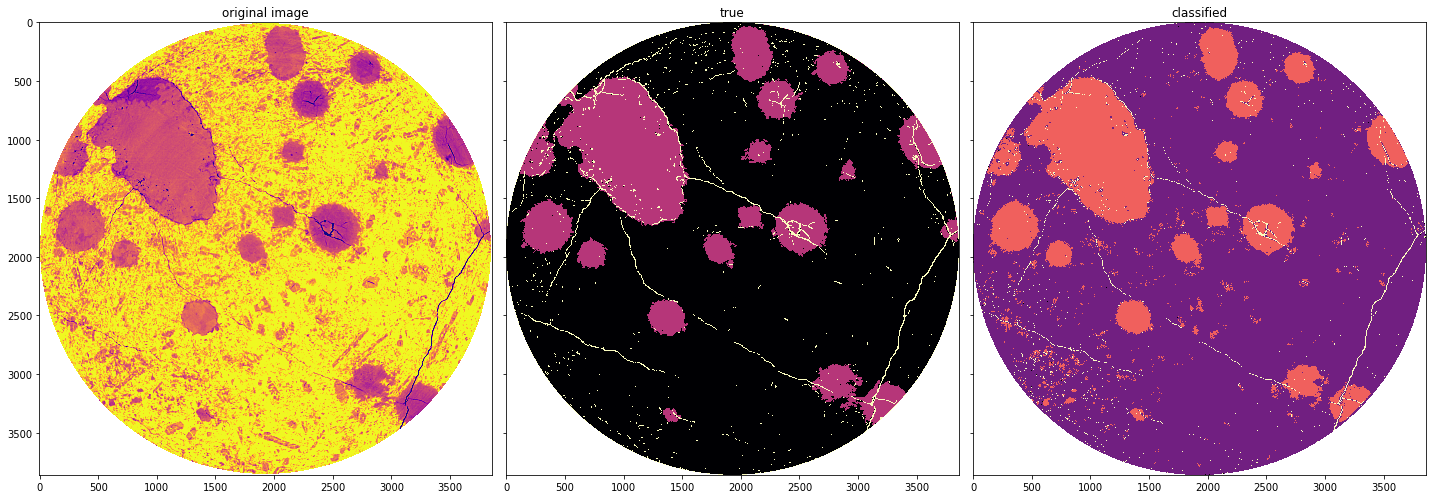

In [84]:
# fig, ax = plt.subplots(1, 3, figsize=(20, 10))
# ax[0].imshow(test_rot90, cmap='plasma', vmin=80, vmax=100)
# ax[1].imshow(test_img90, cmap='plasma')
# ax[2].imshow(test_rot90 - test_img90, cmap='seismic', interpolation='none')
# fig.tight_layout()

fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
ax[0].imshow(helpers.remove_data_based_on_radius(test_rot90, np.nan), cmap='plasma', vmin=80, vmax=100)
ax[1].imshow(helpers.remove_data_based_on_radius(class_rot90, np.nan), cmap='magma', interpolation='none')
ax[2].imshow(helpers.remove_data_based_on_radius(test_img90, np.nan), cmap='magma', interpolation='none')

# fig.colorbar(cbar)

ax[0].set_title('original image')
ax[1].set_title('true')
ax[2].set_title('classified')
fig.tight_layout()

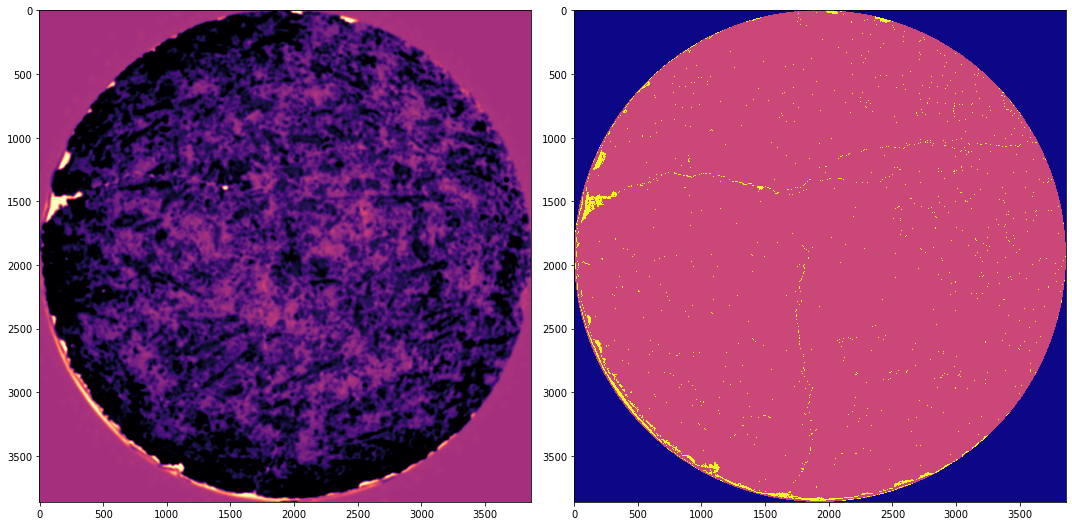

In [192]:
f2011img = cv2.imread('/home/john/research/faroeislands/benoitdata/F20-11/HA-900_6um_jamtveit_att_pag-2.29_3.40_05665.tif', 0)
f2011label = np.load('/media/sda/data/labeled/F20_11/HA-900_6um_jamtveit_att_pag-2.29_3.40_05665.tif_labeled.npy')

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(filters.gaussian(f2011img, sigma=10), cmap='magma_r', vmin=0.35, vmax=0.45)
ax[1].imshow(f2011label, cmap='plasma', interpolation='none')
fig.tight_layout()

In [193]:
test_data = imgData(f2011img, f2011label)

dmatrix_test = xgboost.DMatrix(test_data.get_xdata(), label=test_data.get_ydata())

/home/john/anaconda3/envs/faroe/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


In [194]:
preds_train = xgb.predict(dmatrix_test)

In [195]:
test_img = test_data.get_coordinates().copy()
test_img['rocktype'] = preds_train
test_img = test_img.pivot_table(index='y', columns='x', values='rocktype').values

''

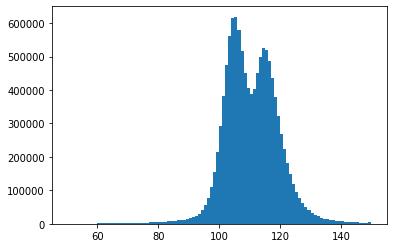

In [213]:
plt.hist(helpers.remove_data_based_on_radius(f2011img, np.nan).ravel(), bins=np.linspace(50, 150, 101))
''

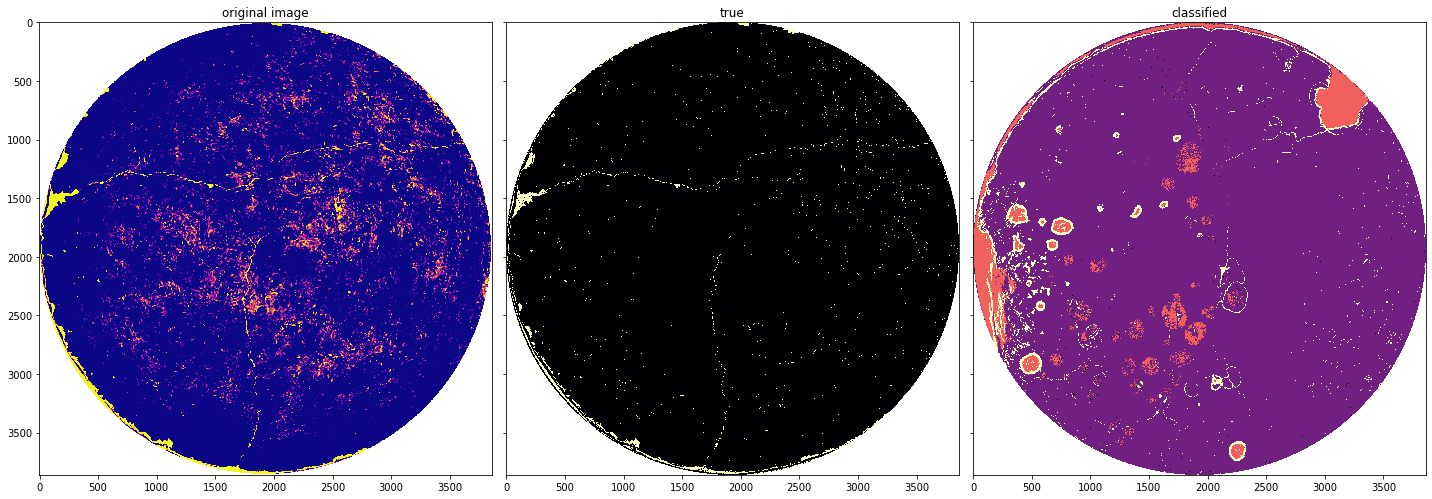

In [223]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
ax[0].imshow(helpers.remove_data_based_on_radius(f2011img, np.nan), vmin=100, vmax=105, cmap='Greys')
ax[1].imshow(helpers.remove_data_based_on_radius(f2011label, np.nan), cmap='magma', interpolation='none')
ax[2].imshow(helpers.remove_data_based_on_radius(test_img, np.nan), cmap='magma', interpolation='none')

# fig.colorbar(cbar)

ax[0].set_title('original image')
ax[1].set_title('true')
ax[2].set_title('classified')
fig.tight_layout()

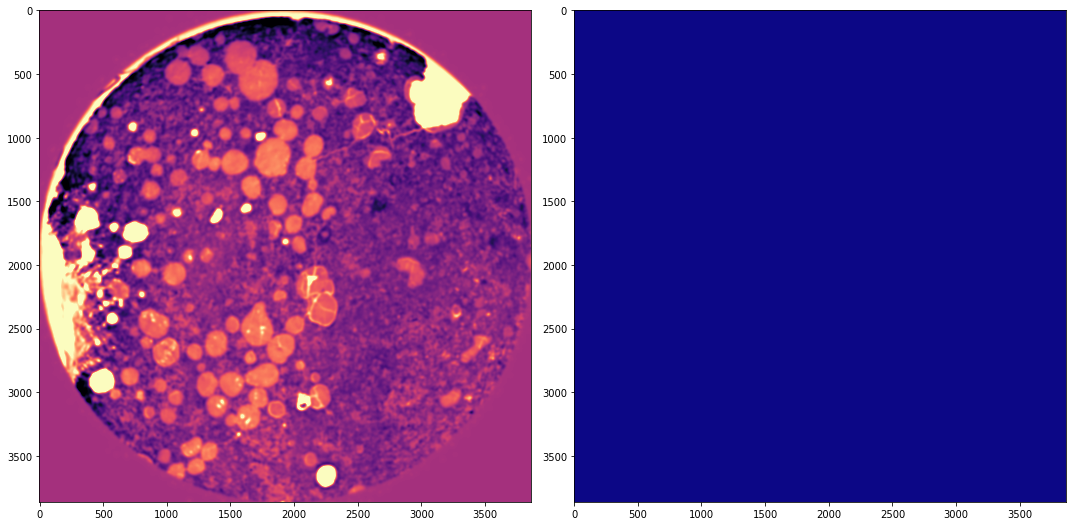

In [198]:
f2014img = cv2.imread('/home/john/research/faroeislands/benoitdata/F20-14A/HA-900_6um_jamtveit_att_pag-2.29_3.40_02040.tif', 0)
f2014label = np.ones_like(f2014img)# np.load('/media/sda/data/labeled/F20_11/HA-900_6um_jamtveit_att_pag-2.29_3.40_05665.tif_labeled.npy')

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(filters.gaussian(f2014img, sigma=10), cmap='magma_r', vmin=0.35, vmax=0.45)
ax[1].imshow(f2014label, cmap='plasma', interpolation='none')
fig.tight_layout()

In [199]:
test_data = imgData(f2014img, f2014label)

dmatrix_test = xgboost.DMatrix(test_data.get_xdata(), label=test_data.get_ydata())

/home/john/anaconda3/envs/faroe/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


In [200]:
preds_train = xgb.predict(dmatrix_test)

In [201]:
test_img = test_data.get_coordinates().copy()
test_img['rocktype'] = preds_train
test_img = test_img.pivot_table(index='y', columns='x', values='rocktype').values

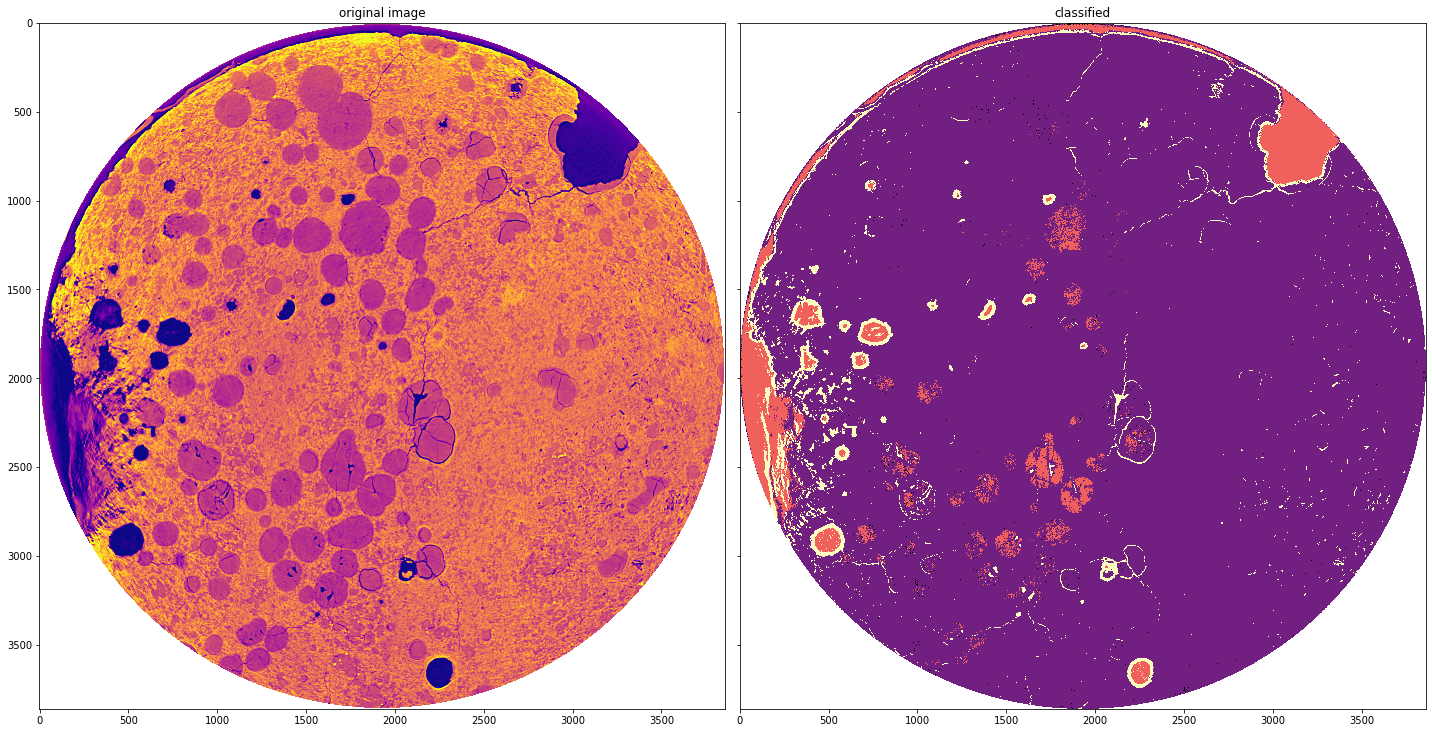

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].imshow(helpers.remove_data_based_on_radius(f2014img, np.nan), cmap='plasma', vmin=80, vmax=120)
# ax[1].imshow(helpers.remove_data_based_on_radius(f2014label, np.nan), cmap='magma', interpolation='none')
ax[1].imshow(helpers.remove_data_based_on_radius(test_img, np.nan), cmap='magma', interpolation='none')

# fig.colorbar(cbar)

ax[0].set_title('original image')
# ax[1].set_title('true')
ax[1].set_title('classified')
fig.tight_layout()

In [18]:
# index = [i for i in itertools.combinations_with_replacement(np.arange(0, raw_image.shape[0], 1).astype(np.uint8), r=2)]

In [19]:
# [i for i in itertools.combinations_with_replacement([1,2,3], r=2)]

In [20]:
# print(len(index))
# raw_image.shape[0]*raw_image.shape[1]

In [21]:
# xx, yy = np.meshgrid([1,2,3], [1,2,3])
# for x, y in zip(xx.ravel(), yy.ravel()):
#     print(x, y)

In [22]:
# footprint1 = np.array(
#     [[1, 1, 1]
#     ,[1, 0, 1]
#     ,[1, 1, 1]]
#     )

# footprint2 = np.array(
#     [[1, 1, 1, 1, 1]
#     ,[1, 1, 1, 1, 1]
#     ,[1, 1, 0, 1, 1]
#     ,[1, 1, 1, 1, 1]
#     ,[1, 1, 1, 1, 1]]
#     )

In [23]:
# train_data = pd.DataFrame()

# xx, yy = np.meshgrid(np.arange(0, train_raw_image.shape[0], 1)
#                     ,np.arange(0, train_raw_image.shape[1], 1))

# train_data['x'] = xx.ravel()
# train_data['y'] = yy.ravel()

In [24]:
# train_data

In [25]:
# normed_raw_image = raw_image / 255.
# # blur = cv2.Gaus

# train_data['meijering'] = filters.meijering(normed_raw_image).ravel()
# train_data['non_local_mean'] = helpers.zscore(normed_raw_image).ravel()
# train_data['laplace_25'] = filters.laplace(normed_raw_image, ksize=25).ravel()
# train_data['sato'] = filters.sato(normed_raw_image).ravel()
# train_data['sobel'] = filters.sobel(normed_raw_image).ravel()
# train_data['median_3'] = filters.median(normed_raw_image, selem=footprint1).ravel()
# train_data['maximum_5'] = ndimage.maximum_filter(normed_raw_image, footprint=footprint2, mode='constant').ravel()
# train_data['yhat'] = classified_image.ravel() + 1

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]], test_size=0.3, random_state=42)

In [27]:
# train_data.yhat.unique()

In [28]:
# dmatrix_train = xgboost.DMatrix(X_train, label=y_train)
# dmatrix_test = xgboost.DMatrix(X_test, label=y_test)

In [29]:
# params = {'objective':'multi:softmax', num_class=4}
# # 
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

In [30]:
# helpers.plot_image(filters.meijering(raw_image))
# helpers.plot_image(filters.sato(raw_image))
# helpers.plot_image(filters.scharr(normed_raw_image))
# helpers.plot_image(filters.sobel(normed_raw_image))

In [31]:
# helpers.plot_image(classified_image)